In [4]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/CSF/Recordings"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

global df = DataFrame(filename=files, Rcsf=NaN, E=NaN, Ib=NaN, P0=NaN, mode=NaN, error=NaN, R2=NaN, Pss=NaN)

for j = 1141
    # try
        j in [278, 442, 521, 621, 676, 1043] ? (continue) : 0

        P_0 = nothing
        Pss = nothing
        GC.gc()

        filename = files[j]
        global Data = readCSF(filename)

        length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
        global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])

        global lb = [0.1, 0.1, -10.0]
        global ub = [50.0, 1.0, Data["P_b"]]
        global Ib_upper = 1.0
        global Ib_lower = 0.0

        optalg = LBFGS()
        # optalg = NelderMead()
        # optalg = Newton()
        x0 = [Data["Rcsf"], Data["E"], Data["P_0"]]

        # x0 = [(Data["P_b"] - Data["P_0"]) / 0.35, Data["E"], Data["P_0"]]

        result, min_val = local_opt(x0, optalg)

        global Rcsf, E, P_0 = Optim.minimizer(result)

        if typeof(Pss) != Nothing
            global df.Pss[j] = round(Pss, digits=3)
            global I_b = (Data["P_b"] - Pss) / Rcsf
        else
            global df.Pss[j] = round(P_0, digits=3)
            global I_b = (Data["P_b"] - P_0) / Rcsf
        end
        df.Rcsf[j] = round(Rcsf, digits=3)
        df.P0[j] = round(P_0, digits=3)
        df.Ib[j] = round(I_b, digits=3)
        df.E[j] = round(E, digits=3)
        df.filename[j] = filename[length(datapath)+2:end]
        df.error[j] = round(calc_model_plot((Data["P_b"] - P_0)/Rcsf, E, P_0)[2], digits=3)
        volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, P_0)
        df.R2[j] = round(R2, digits=3)
end
# CSV.write("/Users/jjc/CSF/Results/Results_NelderMead.csv", df);
plotmodel(I_b, E, P_0, "dark", "")
plot!(size=(600,600))
# savefig("/Users/jjc/Documents/Personal_Website/jeremi-chabros.github.io/img/icpdyn.png")
icp = DataFrame(icp=zeros(length(Data["ICP"])))
icp.icp = Data["ICP"]
CSV.write("/Users/jjc/CSF/Results/sample.csv", icp)
# Data["ICP"]


"/Users/jjc/CSF/Results/sample.csv"

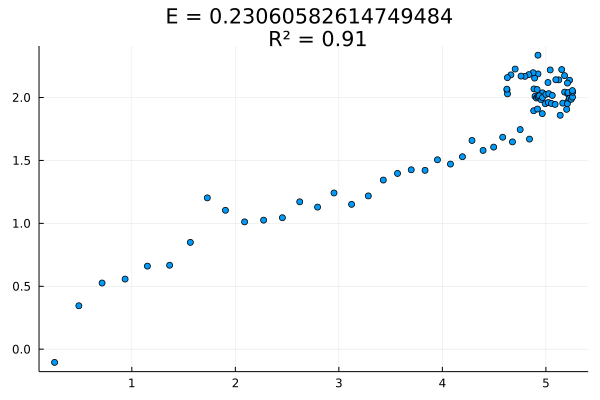

In [72]:
function press_vol_curve(Rcsf, P_0)
    P_b = Data["P_b"]
    I_inf = Data["I_inf"]

    I_b = (P_b - P_0) / Rcsf

    st = Int64(round(length(Pm) * 0.1, digits=0))
    en = Int64(round(length(Pm) * 0.9, digits=0))
    npts = abs(en - st)

    dpress = zeros(length(Pm))
    dvol = zeros(length(Pm))
    # dpress = zeros(npts)
    # dvol = zeros(npts)
    # for i = st:en

    for i = 2:length(Pm)

        dvol[i] = dvol[i-1] + (I_inf + I_b - (Pm[i] - P_0) / Rcsf) * 1 / 6
        dpress[i] = (Pm[i] - P_0) / (P_b - P_0)
    end

    E = dpress./(dvol.*(Pm .- P_0))

    volRes = dvol[dpress.>0]
    pressRes = dpress[dpress.>0]
    y = log.(pressRes)
    coefval = CurveFit.curve_fit(LinearFit, volRes, y)
    fitted_curve = coefval.(volRes)
    ydash = mean(y)
    SSres = sum((y .- fitted_curve) .^ 2)
    SStot = sum((y .- ydash) .^ 2)
    R2 = 1 - (SSres / SStot)
    MSE = SSres / length(y)

    return volRes, pressRes, fitted_curve, R2, MSE, E
end
global volRes, pressRes, fitted_curve, R2, MSE, E = press_vol_curve(Rcsf, P_0)

# volRes = volRes[3:end-50]
# pressRes = pressRes[3:end-50]
# E = round(mean(E[3:end-50]),digits=2)
E = mean(E[2:end])
plot(volRes, log.(pressRes), seriestype=:scatter, title="E = $E \n R² = $(round(R2,digits=2))", legend=false)



0.887
0.674


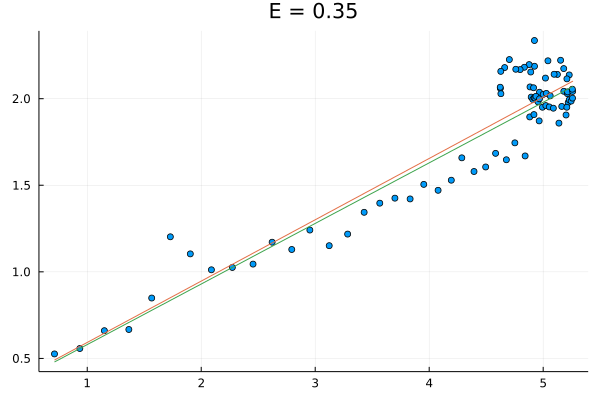

In [96]:
using Optim
function l2reg(X)
    err = sqrt(sum(((X[1] .* x .+ X[2]) .- y).^2)/length(x))
    return err
end
function l1reg(X)
    err = sum(abs.((X[1] .* x .+ X[2]) .- y))
    return err
end

global x = volRes[3:end]
global y = log.(pressRes[3:end])

plot(x,y, seriestype=:scatter, legend=false)

x0 = [1.0,1.0]
optalg = LBFGS()
result = Optim.optimize(l2reg, x0, optalg)
a, c = Optim.minimizer(result)
plot!(x, a.*x .+ c)

ydash = mean(y)
SSres = sum((y .- (a.*x .+ c)) .^ 2)
SStot = sum((y .- ydash) .^ 2)
R2 = 1 - (SSres / SStot)
MSE = SSres / length(y)
println(round(R2,digits=3))

result = Optim.optimize(l1reg, x0, optalg)
a, c = Optim.minimizer(result)
plot!(x, a.*x .+ c)

ydash = mean(y)
SSres = sum(abs.(y .- (a.*x .+ c)))
SStot = sum(abs.(y .- ydash))
R2 = 1 - (SSres / SStot)
MSE = SSres / length(y)
println(round(R2,digits=3))

title!("E = $(round(a,digits=2))")


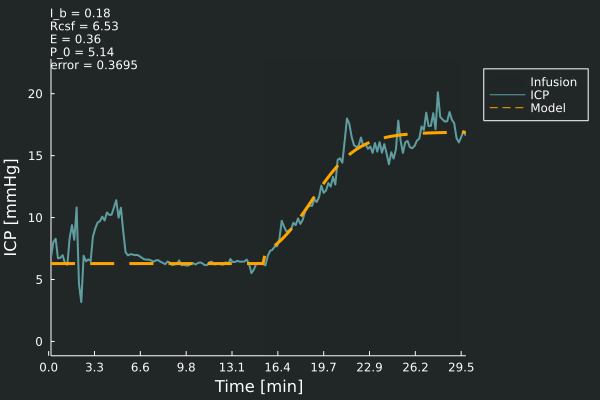

In [4]:
# BRUTEFORCE


Rdist = LinRange(0.0, 50.0, 200)
Edist = LinRange(0.0, 1.0, 100)
P0dist = LinRange(-10.0, Data["P_b"], 100)

M = [[i,j,k, calc_model_plot((Data["P_b"] - k)/i, j, k)[2]] for i in Rdist, j in Edist, k in P0dist]
# M = [[i,j,k, calc_model_plot_Pss((Data["P_b"] - k)/i, j)[2]] for i in Rdist, j in Edist, k in P0dist]


a = reshape(M,2000000,1)

tormv = zeros(length(a))
for i = eachindex(a)
    isnan.(a[i][4]) ? a[i][4] = 10^12 : 0
    tormv[i] = a[i][4]
end

s = findmin(tormv)
s = s[2]
global Rcsf, E, P_0 = a[s][1], a[s][2], a[s][3]
global I_b = (Data["P_b"] - P_0) / Rcsf
plotmodel(I_b, E, P_0, "dark", "")




In [7]:
plot(a[2:end],seriestype=:surface)

LoadError: UndefVarError: a not defined

In [8]:
using Nonconvex
Nonconvex.@load BayesOpt

f(x) = sqrt(x[2])
g(x, a, b) = (a*x[1] + b)^3 - x[2]

model = Model()
set_objective!(model, f, flags = [:expensive])
addvar!(model, [1e-4, 1e-4], [10.0, 10.0])
add_ineq_constraint!(model, x -> g(x, 2, 0), flags = [:expensive])
add_ineq_constraint!(model, x -> g(x, -1, 1))

alg = BayesOptAlg(IpoptAlg())
options = BayesOptOptions(
    sub_options = IpoptOptions(),
    maxiter = 50, ftol = 1e-4, ctol = 1e-5,
)
r = optimize(model, alg, [1.234, 2.345], options = options)